In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import random as rd

In [2]:
df = pd.read_csv('Stage-3.csv') # opens the .csv file as a data frame
df

Numéro  Position  Pression (Torr)  Ch. Magnétique (T) Gaz  \
0       33       0.0              0.0                 0.0  N2   
1       34       1.4              5.0                 0.0  N2   
2       35       2.0              5.0                 0.0  N2   
3       36       2.6              5.0                 0.0  N2   
4       37       1.4              5.0                 1.5  N2   
5       38       2.0              5.0                 1.5  N2   
6       39       2.6              5.0                 1.5  N2   
7       41       1.4              1.0                 0.0  N2   
8       42       2.0              1.0                 0.0  N2   
9       43       2.6              1.0                 0.0  N2   
10      44       1.4              1.0                 2.0  N2   
11      45       2.0              1.0                 2.0  N2   
12      46       2.6              1.0                 2.0  N2   
13      47       1.4              1.0                 2.0  N2   
14      48       2.0              1.0                 2.0  N2   
15      49       2.6              1.0                 2.0  N2   
16      51       1.4              1.0                 2.0  N2   
17      52       2.0              1.0                 2.0  N2   
18      53       2.6              1.0                 2.0  N2   
19      54       1.4              1.0                 0.0  N2   
20      55       2.0              1.0                 0.0  N2   
21      56       2.6              1.0                 0.0  N2   
22      57       1.4              1.0                 0.0  N2   
23      58       2.0              1.0                 0.0  N2   
24      59       2.6              1.0                 0.0  N2   
25      61       1.4              1.0                 0.0  N2   
26      62       2.0              1.0                 0.0  N2   
27      63       2.6              0.5                 0.0  N2   
28      64       1.4              0.5                 0.0  N2   
29      65       2.0              0.5                 0.0  N2   
30      66       2.6              0.5                 2.0  N2   
31      67       1.4              7.0                 2.0  He   
32      68       2.0              7.0                 0.0  He   
33      69       2.6              7.0                 2.0  He   

    Laser Energy (J)   vi    vf  
0               2892    0     0  
1               2700  200  1100  
2               2842  200   800  
3               2727  300   600  
4               2662  200   700  
5               2682    0     0  
6               2655  300   600  
7               2717  200  1100  
8               2773  200  1100  
9               2715  200   800  
10              2712  200  1000  
11              2662  200   900  
12              2657  200   800  
13              2649  200   900  
14              2548  200   900  
15              2637  200   800  
16              2757    0     0  
17              2775  200   900  
18              2695  200   900  
19              2699  200  1100  
20              2705  200  1100  
21              2631  200   800  
22              2627  200  1100  
23              2679  200  1100  
24              2543  200   800  
25              2690  200  1100  
26              2693  200  1000  
27              2688  200  1000  
28              2636    0     0  
29              2689    0     0  
30              2588    0     0  
31              2591    0     0  
32              2616  300  1000  
33              2582  300   800

In [36]:
def load_image(file_path) : # opens the image
    return np.array(Image.open(file_path))

def pix_to_t(t, tf, ti) : # converts pixels to time (ns)
    return (tf-ti) / 1016 * t + ti

def pix_to_x(x, xf, xi) : # converts pixels to lenght (cm)
    return (xf-xi) / 1344 * x + xi

def fitpow(x, a, b) : # power fit f(t) = at^b 
    return a * np.abs(x) ** b

def fitlin(x, a, b) : # linear fit f(t) = at + b
    return a * x + b

In [63]:
def graph(n, data, v) :

    ligne = data.iloc[n] 

    position = ligne['Position']
    numero = int(ligne['Numéro'])
    gaz = ligne['Gaz']
    p = ligne['Pression (Torr)']
    B = ligne['Ch. Magnétique (T)']
    vi, vf = ligne['vi'], ligne['vf']
    if vi == 0 and vf == 0 :
        return 0, 0, 0, 0, 0, 0
    
    file_path =  f"../Stage_Pic/477{numero}.tif" # opens the image from the folder
    img_data = load_image(file_path) # loads the image for data analysis

    ti, tf = -26.67, 73.1 # initial and final time

    if position == 1.4 : # checks Thompson scattering position
        xi, xf = 0.3, 2.6
    elif position == 2 :
        xi, xf = 0.9, 3.32
    elif position == 2.6 :
        xi, xf = 1.5, 3.9
    else :
        return 0, 0, 0, 0, 0, 0

    if n <= 16 : # checks if the image needs flipping
        img_data = np.flip(img_data, axis = 0)

    x = np.linspace(0,1344,1344) # pixel scale
    P_max = [] # list for intensity maximums

    for ligne in img_data : # gets the maximum intensity for each line
        P_max.append(np.where(ligne == max(ligne))[0][0])
    pts = np.array(P_max)
    
    x_filtre = x[vi:vf] # filters the "noise" from the data
    pts_filtre = np.flip(pts)[vi:vf] # filters the "noise" from the data
    
    x_conv = pix_to_x(x_filtre, xf, xi) # converts x from pixels to cm
    t_conv = pix_to_t(pts_filtre, tf, ti) # converts t from pixels to ns
    
    p0, var0 = curve_fit(fitpow, t_conv, x_conv) # finds the best fit for the data
    a0, b0 = p0

    t_fin = np.linspace(ti, tf, 1016)
    x_pow = fitpow(t_fin, a0, b0) # fits the data to a power fit
    
    i, j = 0,0

    while x_pow[i+1] < x_pow[i] or x_pow[i] < xi : # filters out the out of bound points for the fitted data
        i += 1
    while x_pow[j] <= xf :
        j += 1
        if j == 1016 :
            break
    
    if v == True : # shows the resulting image
        plt.figure(figsize=(9, 5))
        plt.imshow(img_data,
                   cmap='inferno',
                   extent=[ti, tf, xi, xf],
                   aspect='auto',
                   vmax=np.max(img_data))
        plt.colorbar() 
        plt.grid()
        plt.plot(t_fin[i:j], x_pow[i:j], color = '#ff0000', label = 'Ajustement at^b, a = ' + str(a0)[:5] + ', b  = ' + str(b0)[:5])
        plt.xlabel('t (ns)')
        plt.ylabel('x (cm)')
        plt.title(f'Shot n°{numero}, Position = {position} cm, P = {p} Torr, B = {B} T, {gaz}')
        plt.legend()
        plt.show()
    
    return a0, b0, p, B, t_fin, x_pow

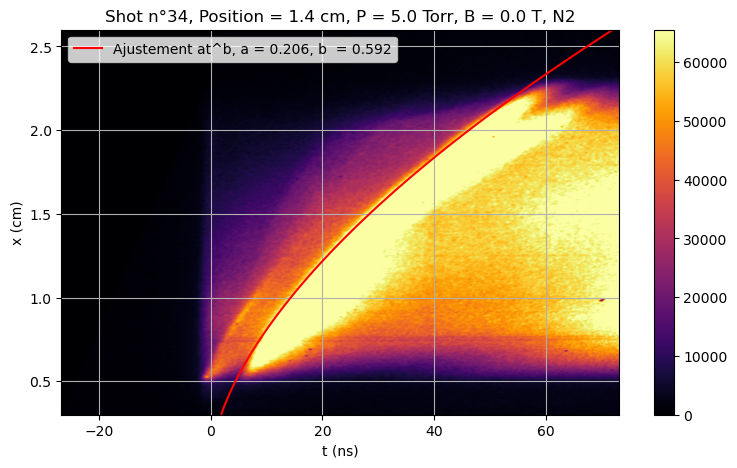

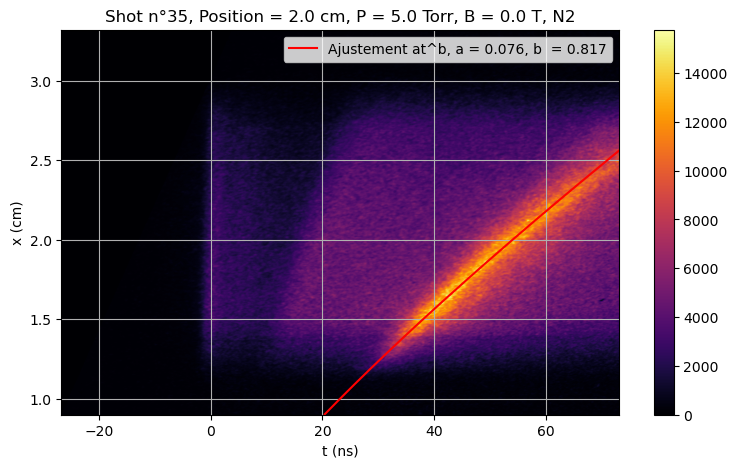

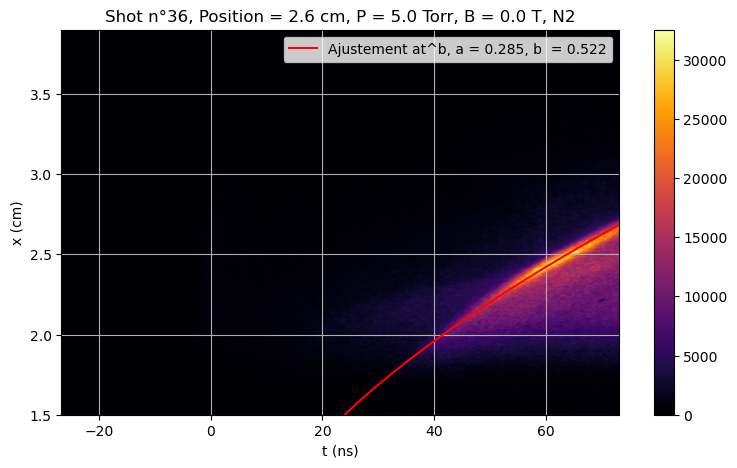

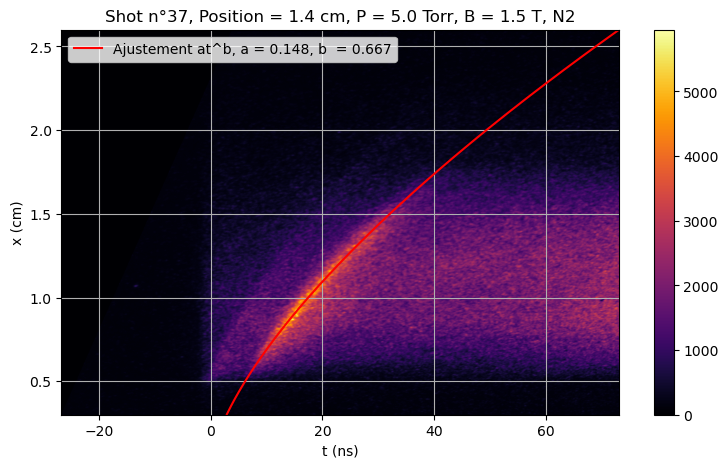

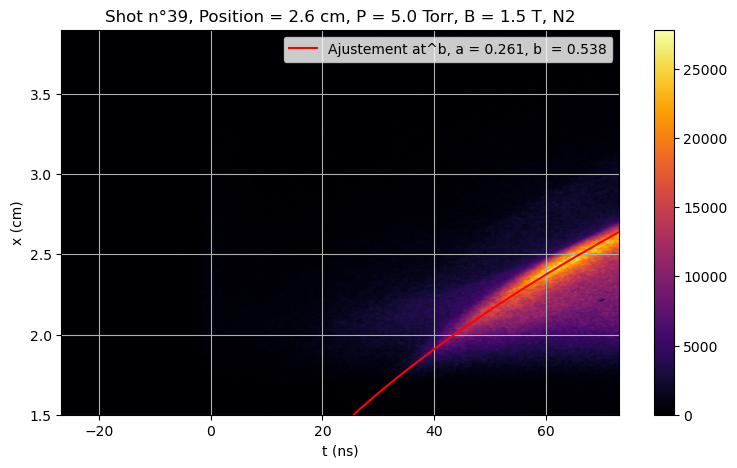

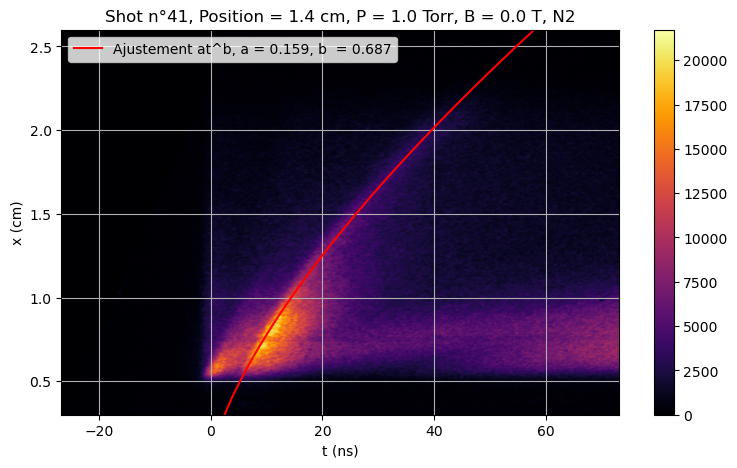

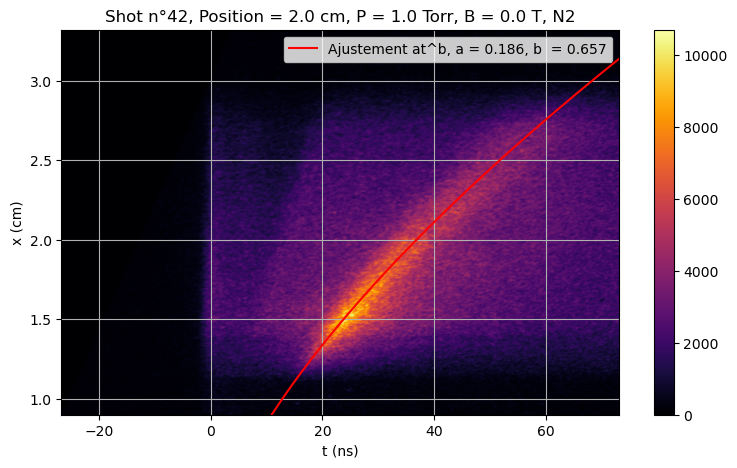

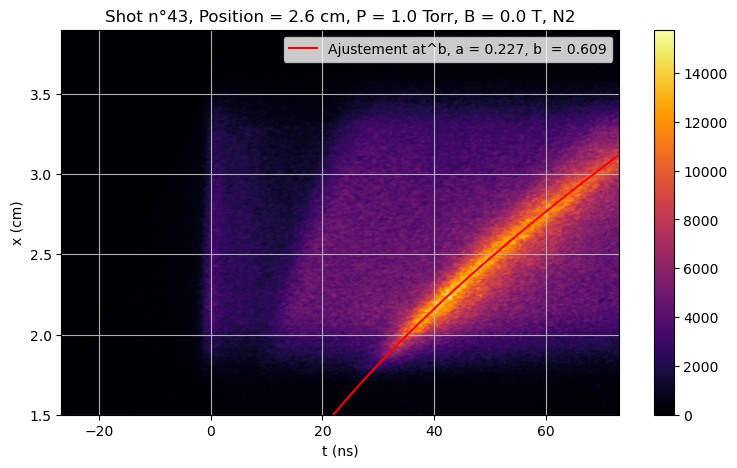

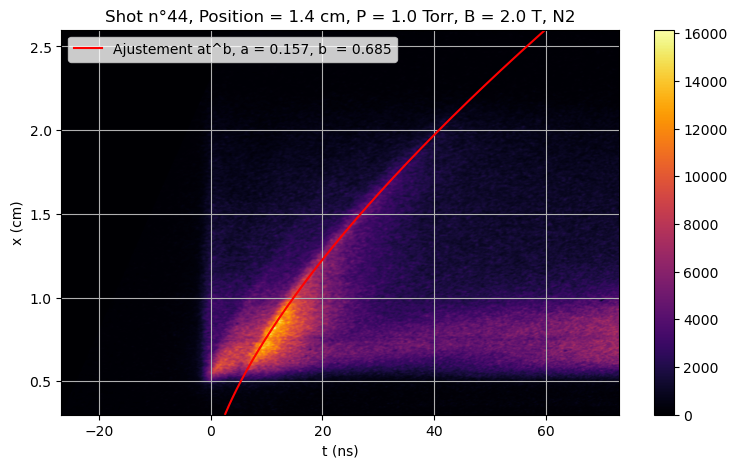

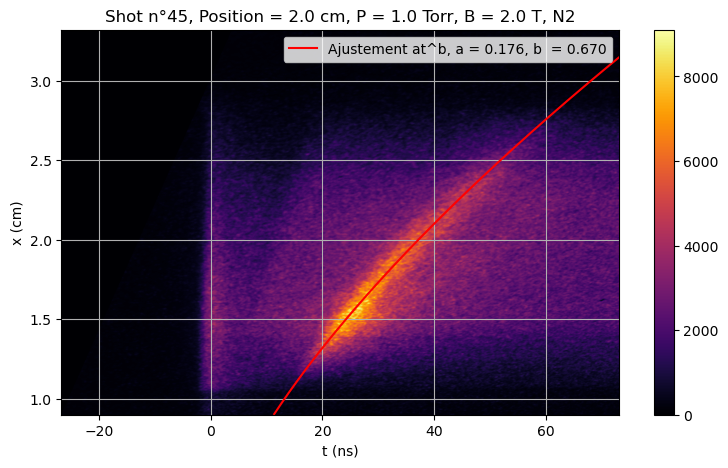

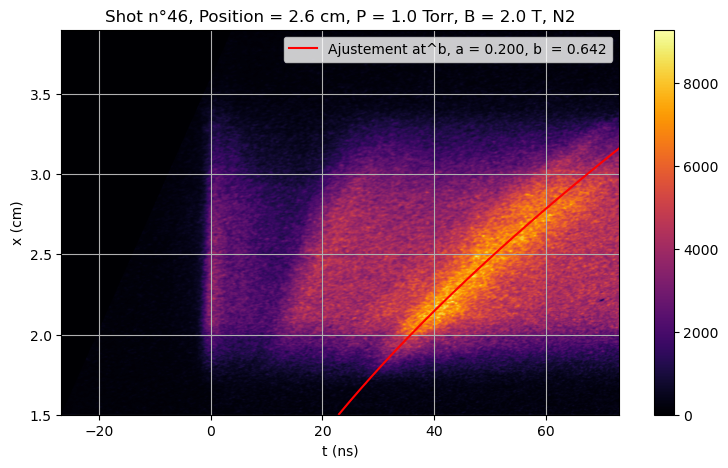

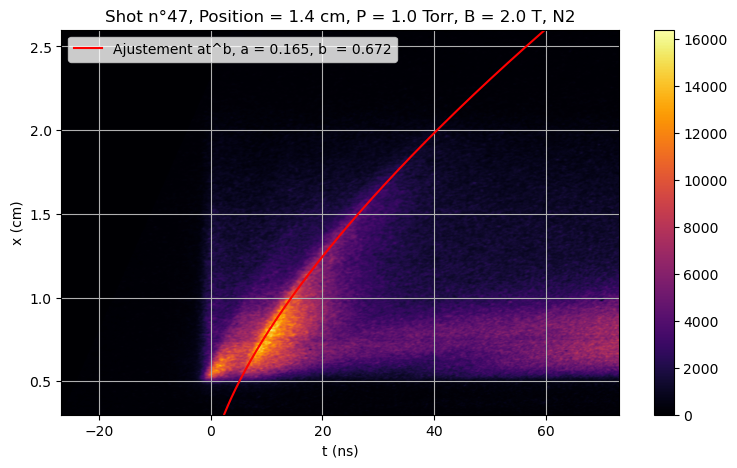

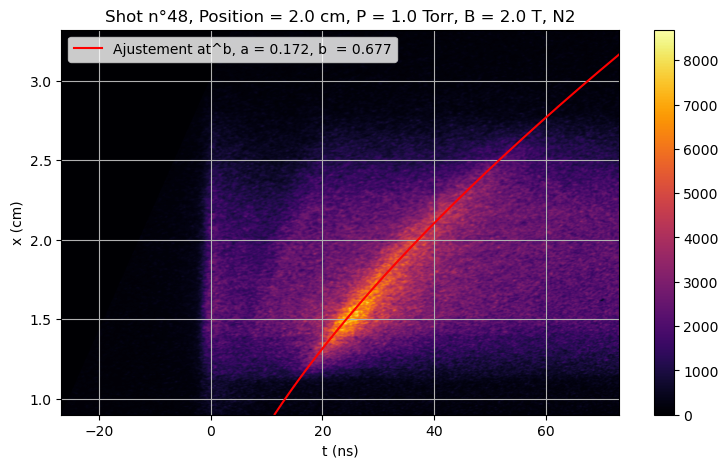

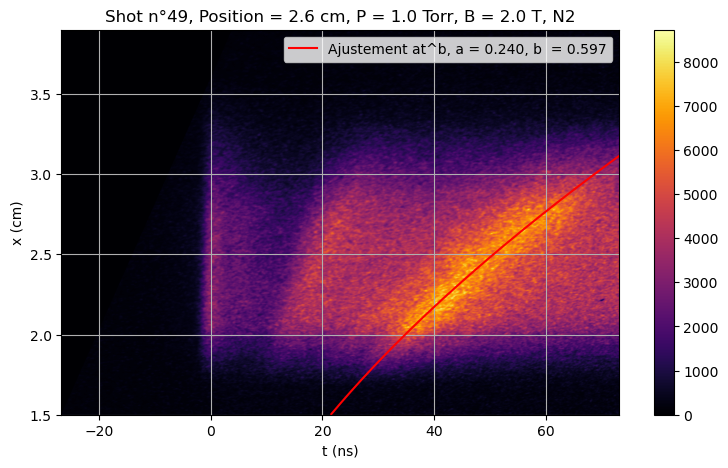

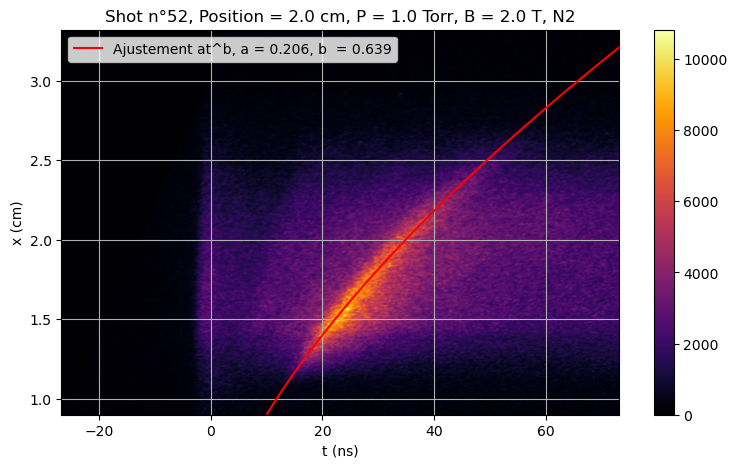

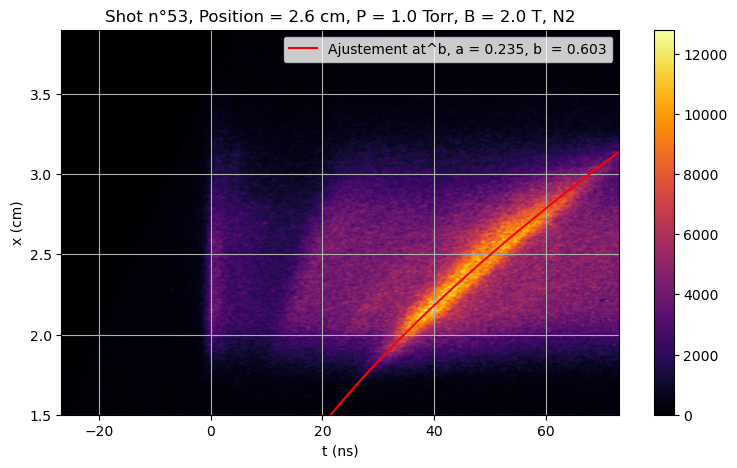

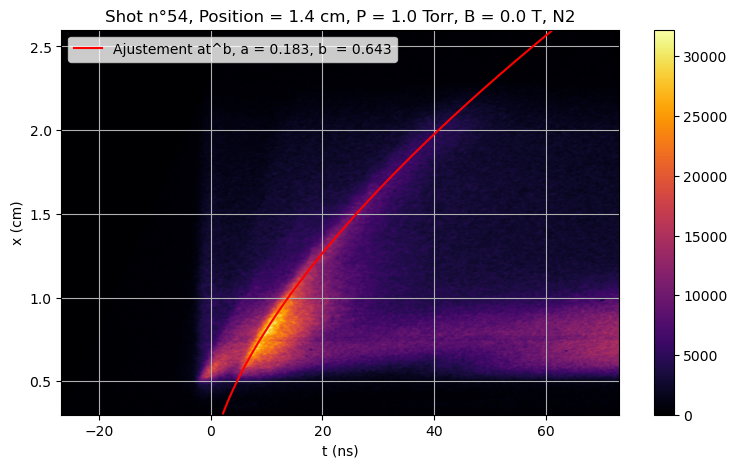

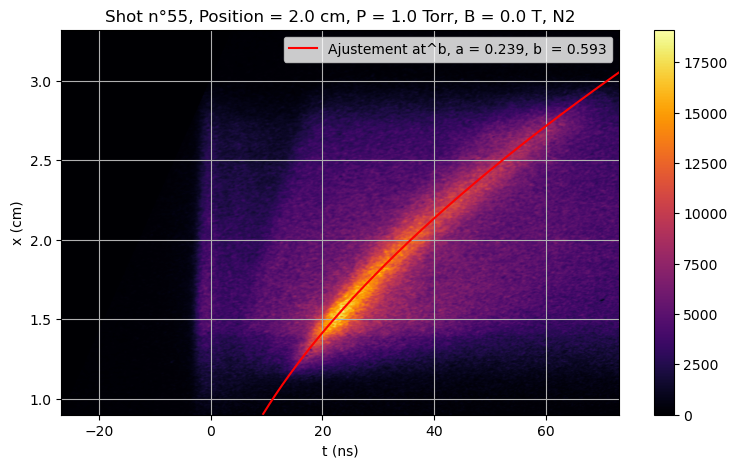

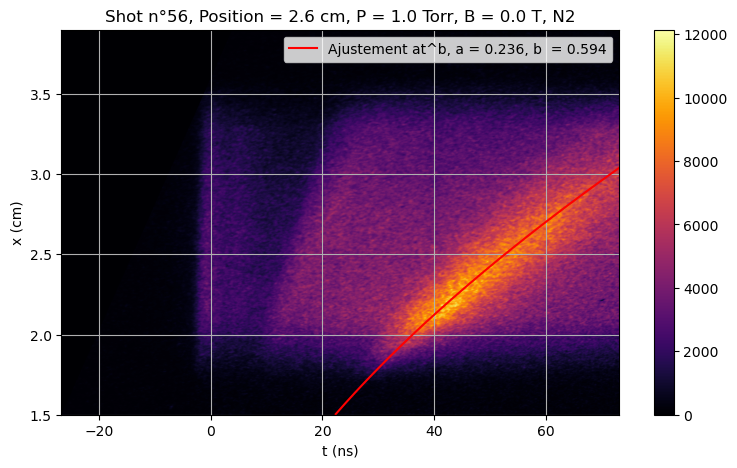

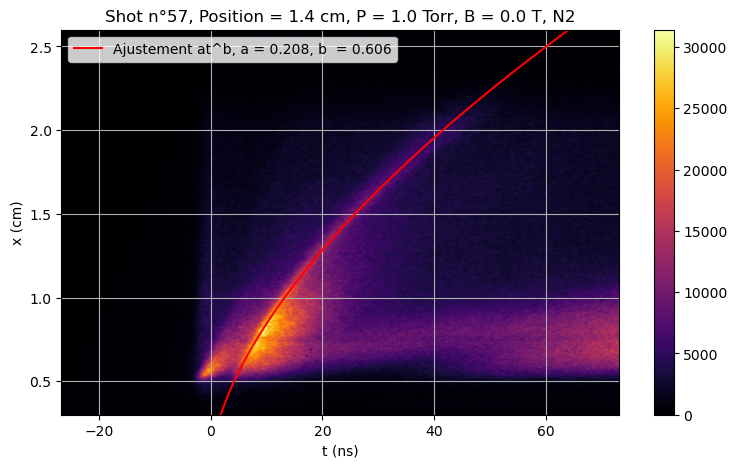

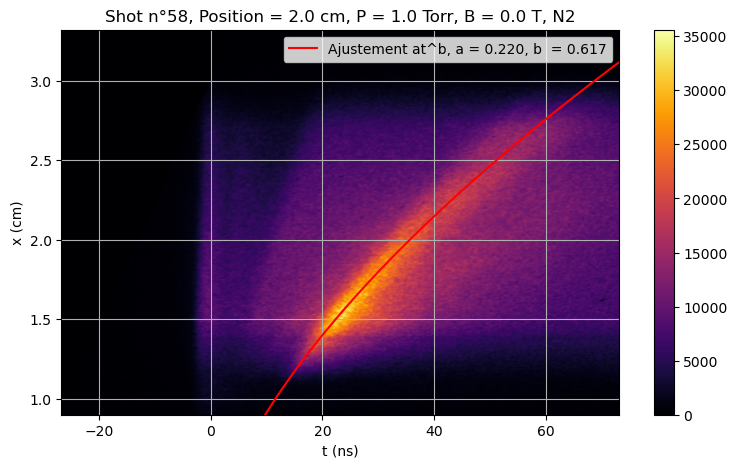

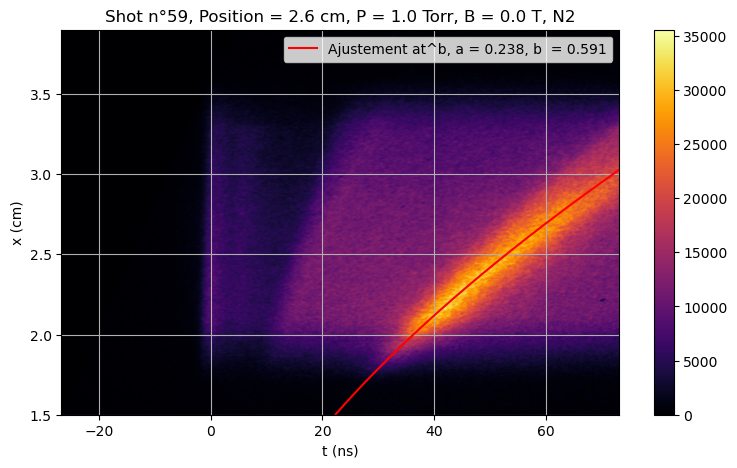

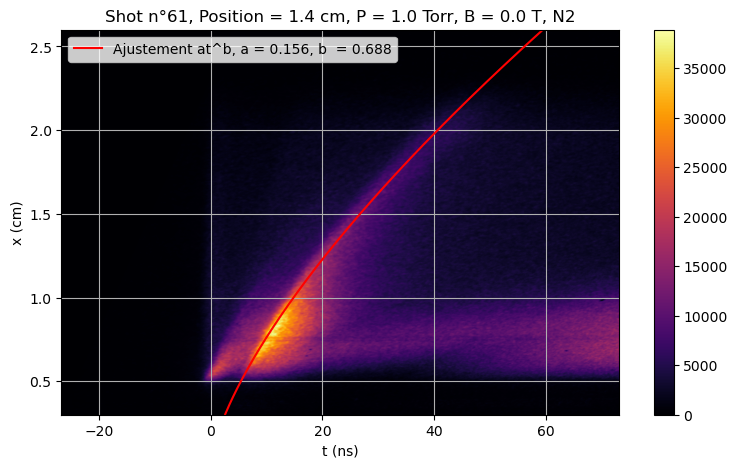

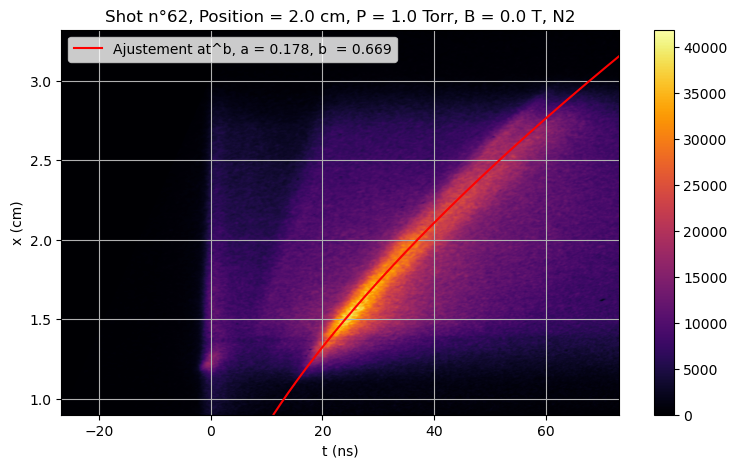

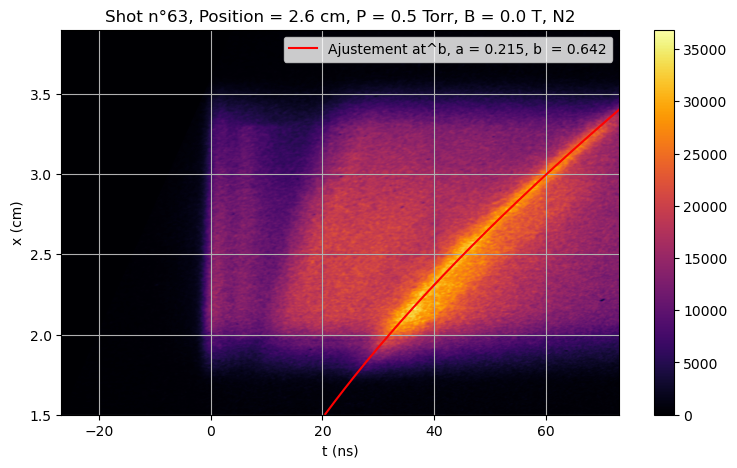

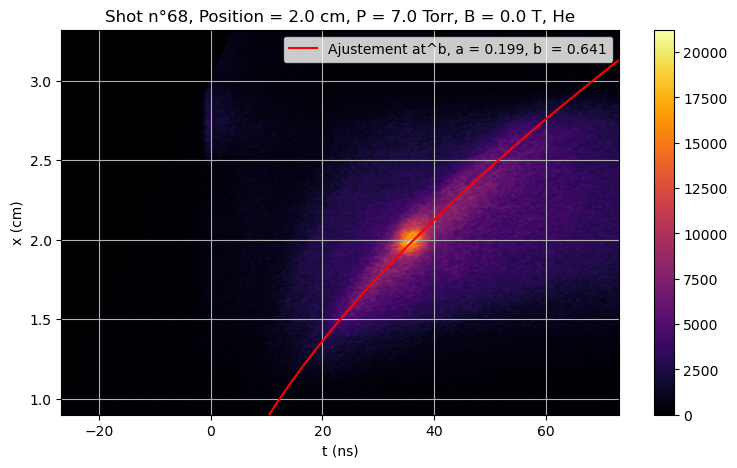

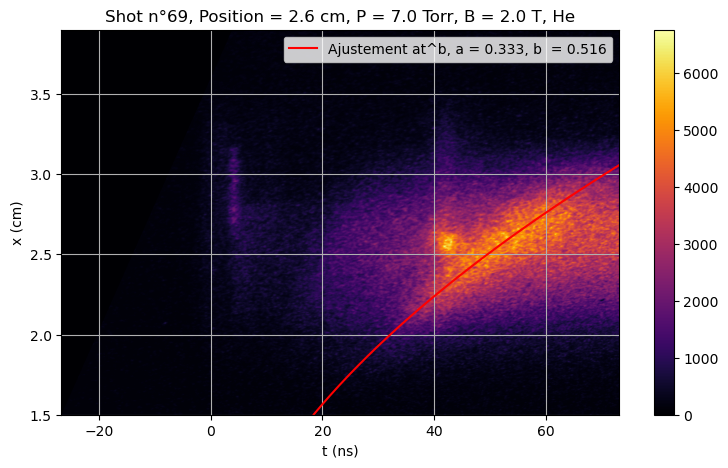

In [62]:
"""
graph(rd.choice([1,2,3,4,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,32,33]), df, True)
"""
for i in range(34) :
    graph(i, df, True)

plt.show()

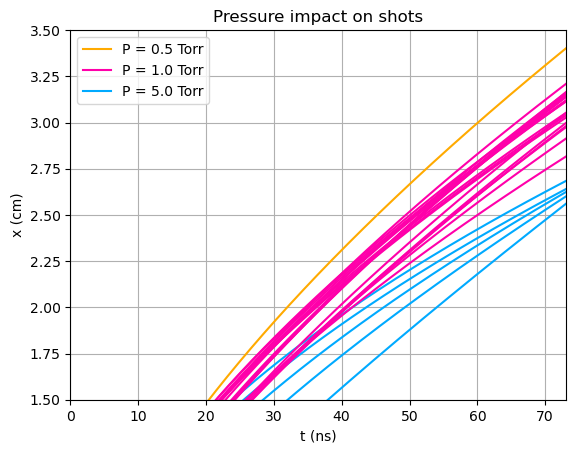

In [12]:
plt.plot(0, 0, color = "#ffaa00", label = 'P = 0.5 Torr')
plt.plot(0, 0, color = "#ff00aa", label = 'P = 1.0 Torr')
plt.plot(0, 0, color = "#00aaff", label = 'P = 5.0 Torr')

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if df['Gaz'][i] != 'He' :
        if p == 0 :
            C = "#ffffff"
        if p == 0.5 :
            C = "#ffaa00"
        if p == 1 :
            C = "#ff00aa"
        if p == 5 :
            C = "#00aaff"
        plt.plot(tc, xc, color = C)

plt.xlim(0,73.1)
plt.ylim(1.5,3.5)
plt.xlabel('t (ns)')
plt.ylabel('x (cm)')
plt.grid()
plt.legend()
plt.title('Pressure impact on shots')
plt.savefig('Pressure impact 1')
plt.show()

It seems the choc's profile is correlated to the gas's pressure.

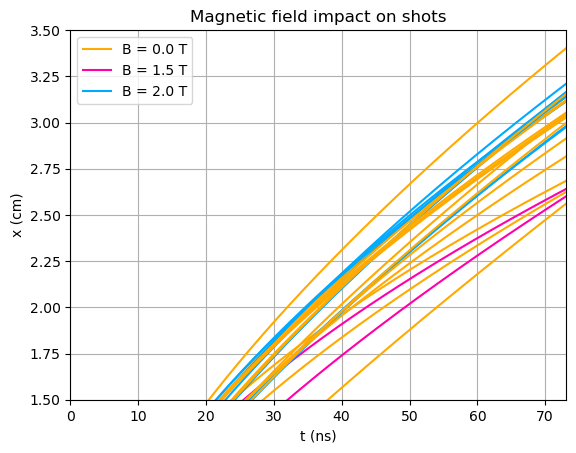

In [7]:
plt.plot(0, 0, color = "#ffaa00", label = 'B = 0.0 T')
plt.plot(0, 0, color = "#ff00aa", label = 'B = 1.5 T')
plt.plot(0, 0, color = "#00aaff", label = 'B = 2.0 T')

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if df['Gaz'][i] != 'He' :
        if B == 0 :
            C = "#ffaa00"
        if B == 1.5 :
            C = "#ff00aa"
        if B == 2 :
            C = "#00aaff"
        plt.plot(tc, xc, color = C)

plt.xlim(0,73.1)
plt.ylim(1.5,3.5)
plt.xlabel('t (ns)')
plt.ylabel('x (cm)')
plt.grid()
plt.legend()
plt.title('Magnetic field impact on shots')
plt.show()

As oposed to pressure, the magnetic field does not seem to impact the choc's profile.

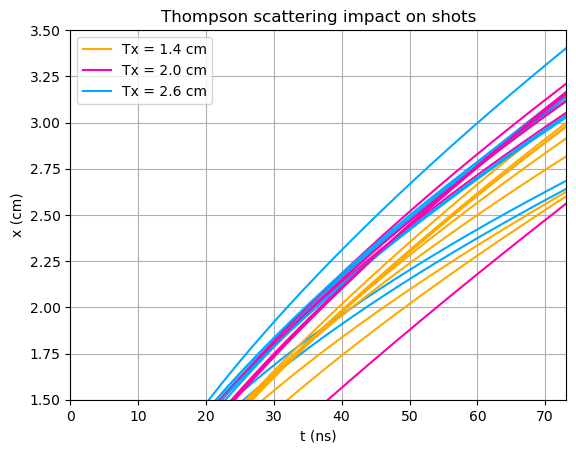

In [8]:
plt.plot(0, 0, color = "#ffaa00", label = 'Tx = 1.4 cm')
plt.plot(0, 0, color = "#ff00aa", label = 'Tx = 2.0 cm')
plt.plot(0, 0, color = "#00aaff", label = 'Tx = 2.6 cm')

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    tx = df['Position'][i]
    if df['Gaz'][i] != 'He' :
        if tx == 1.4 :
            C = "#ffaa00"
        if tx == 2 :
            C = "#ff00aa"
        if tx == 2.6 :
            C = "#00aaff"
        plt.plot(tc, xc, color = C)

plt.xlim(0,73.1)
plt.ylim(1.5,3.5)
plt.xlabel('t (ns)')
plt.ylabel('x (cm)')
plt.grid()
plt.legend()
plt.title('Thompson scattering impact on shots')
plt.show()

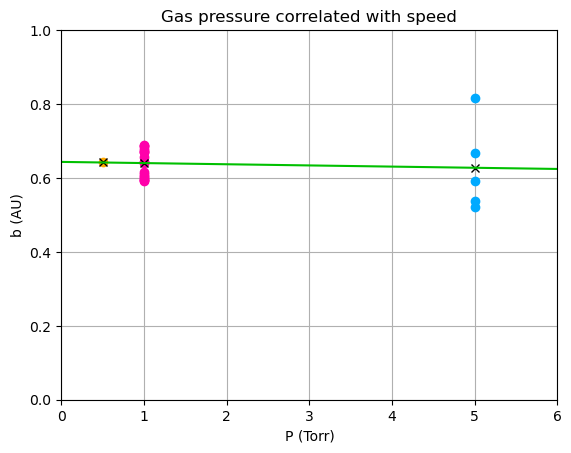

In [52]:
l05, l10, l50= [], [], []

for i in range(34) :
    
    a, b, p, B, tc, xc = graph(i, df, False)
    
    if b != 0 and df['Gaz'][i] != 'He':
        if p == 0.5 :
            plt.plot(p, b, 'o', color = "#ffaa00")
            l05.append(b)
            
        if p == 1 :
            plt.plot(p, b, 'o', color = "#ff00aa")
            l10.append(b)
            
        if p == 5 :
            plt.plot(p, b, 'o', color = "#00aaff")
            l50.append(b)
            
p0, var = curve_fit(fitlin, [0.5, 1, 5], [np.mean(l05), np.mean(l10), np.mean(l50)])
a0, b0 = p0

plt.plot(0.5, np.mean(l05), 'x', color = "#000000")
plt.plot(1, np.mean(l10), 'x', color = "#000000")
plt.plot(5, np.mean(l50), 'x', color = "#000000")

plt.plot(np.linspace(0, 6), fitlin(np.linspace(0, 6), a0, b0), color = "#00c000")
plt.xlim(0,6)
plt.ylim(0,1)
plt.xlabel('P (Torr)')
plt.ylabel('b (AU)')
plt.title('Gas pressure correlated with speed')
plt.grid()
plt.show()

The higher the pressure, the slower the choc propagates.

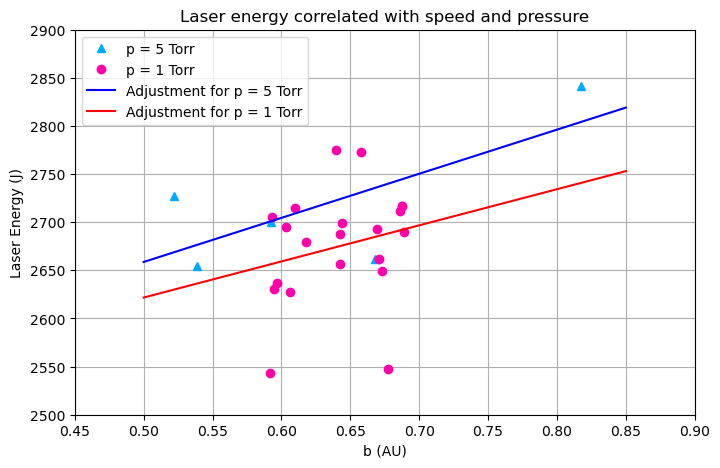

In [65]:
lb10, lE10 = [], []
lb50, lE50 = [], []
t10, t50, = False, False

plt.figure(figsize = (8,5))

for i in range(34) :
    a, b, p, B, tc, xc = graph(i, df, False)
    if a != 0 and df['Gaz'][i] != 'He' :
        E = df['Laser Energy (J)'][i]
        if p == 0.5 :
            None
        if p == 1 :
            C = "#ff00aa"
            S = 'o'
            lb10.append(b)
            lE10.append(E)
        if p == 5 :
            C = "#00aaff"
            S = '^'
            lb50.append(b)
            lE50.append(E)
        if t10 == False and p == 1:
            t10 = True
            plt.plot(b, E, S, color = C, label = 'p = 1 Torr')
        if t50 == False and p == 5:
            t50 = True
            plt.plot(b, E, S, color = C, label = 'p = 5 Torr')
        else :
            plt.plot(b, E, S, color = C)
        
p10, var10 = curve_fit(fitlin, lb10, lE10)
a10, b10 = p10

p50, var50 = curve_fit(fitlin, lb50, lE50)
a50, b50 = p50


plt.plot(np.linspace(0.5, 0.85), fitlin(np.linspace(0.5, 0.85), a50, b50), color = "#0000ff", label = 'Adjustment for p = 5 Torr')
plt.plot(np.linspace(0.5, 0.85), fitlin(np.linspace(0.5, 0.85), a10, b10), color = "#ff0000", label = 'Adjustment for p = 1 Torr')

plt.xlim(0.45,0.9)
plt.ylim(2500,2900)
plt.xlabel('b (AU)')
plt.ylabel('Laser Energy (J)')
plt.title('Laser energy correlated with speed and pressure')
plt.legend()
plt.grid()
plt.show()

The more the laser is energized, the faster the choc propagates. $v\propto b$

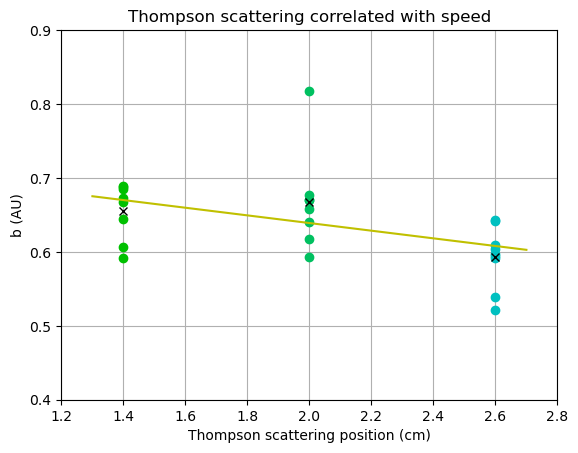

In [11]:
l14, l20, l26 = [], [], []

for i in range(34) :
    
    a, b, p, B, xc, tc = graph(i, df, False)
    
    if a != 0 and df['Gaz'][i] != 'He' :
        Tx = df['Position'][i]
        
        if Tx == 1.4 :
            l14.append(b) 
            plt.plot(1.4, b, 'o', color = "#00c000")
            
        if Tx == 2 :
            l20.append(b) 
            plt.plot(2, b, 'o', color = "#00c060")
            
        if Tx == 2.6 :
            l26.append(b) 
            plt.plot(2.6, b, 'o', color = "#00c0c0")
            
plt.plot([1.4, 2, 2.6], [np.mean(l14), np.mean(l20), np.mean(l26)], 'x', color = "#000000")

p0, var = curve_fit(fitlin, [1.4, 2, 2.6], [np.mean(l14), np.mean(l20), np.mean(l26)])
a0, b0 = p0

plt.plot(np.linspace(1.3, 2.7, 1000), fitlin(np.linspace(1.3, 2.7, 1000), a0, b0), color = "#c0c000")

b14, b20, b26 = np.mean(l14), np.mean(l20), np.mean(l26)
plt.xlim(1.2, 2.8)
plt.ylim(0.4, 0.9)
plt.xlabel('Thompson scattering position (cm)')
plt.ylabel('b (AU)')
plt.title('Thompson scattering correlated with speed')
plt.grid()
plt.show()

The further the Thompson scattering, the slower the choc propagates.